In [1]:
import json
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import SimpleRNN, GRU, LSTM
from keras.layers.core import Dense, Dropout
from keras.layers.wrappers import TimeDistributed
from keras.layers import Convolution1D, MaxPooling1D
from keras.utils import np_utils
import itertools
import ast
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import sys, os
import traceback
from itertools import chain
import numpy as np
import pandas as pd

import progressbar

import tensorflow as tf
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
def read_data(rootdir):
    data_list = []
    for subdir, dirs, files in os.walk(rootdir):
        for fname in files:
            #print os.path.join(subdir, file)
            filepath = subdir + os.sep + fname
            with open(filepath) as f:
                for line1,line2 in itertools.izip_longest(*[f]*2):
                    try:
                        text = ast.literal_eval(line1)
                        label = ast.literal_eval(line2)
                        n_labels = set(label)
                        if len(text) > 3 and len(n_labels) > 1:
                            sentence = zip(text, label)
                            sentence = [item for item in sentence if item[0].strip() != '']
                            data_list.append(sentence)
                    except:
                        pass
            f.close()
    return data_list

In [4]:
data_list = read_data('../data/input/output_cl/')

print data_list[0]

# data_list = data_list[:3000]

# words = list(chain.from_iterable(data_list))
# print words

words = list(set(y[0] for x in data_list for y in x))
words.append("ENDPAD")
n_words = len(words); n_words

tags = list(set(y[1] for x in data_list for y in x))
n_tags = len(tags); n_tags

[('A', 'NA'), ('Hybrid', 'NA'), ('Photoreceptor', 'CL:0000210'), ('Expressing', 'NA'), ('Both', 'NA'), ('Rod', 'CL:0000604'), ('and', 'NA'), ('Cone', 'CL:0000573'), ('Genes', 'NA'), ('in', 'NA'), ('a', 'NA'), ('Mouse', 'NA'), ('Model', 'NA'), ('of', 'NA'), ('Enhanced', 'NA'), ('SCone', 'NA'), ('Syndrome', 'NA')]


68

In [5]:
# from sklearn.preprocessing import LabelEncoder

# le = LabelEncoder()
# le.fit(list(y[1] for x in data_list for y in x))

# labels2idx = dict(zip(le.classes_, le.transform(le.classes_)))

# idx2la = {labels2idx[k]:k for k in labels2idx}

In [6]:
max_len = 75
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags, 1)}
tag2idx['0'] = 0
n_tags += 1

idx2tag = {v: k for k, v in tag2idx.iteritems()}

print word2idx['Hybrid']
print tag2idx["NA"]

705
23


In [7]:
print tag2idx

{'CL:0000775': 1, 'CL:0000558': 2, 'CL:0000100': 3, 'CL:0000127': 4, 'CL:0000771': 5, 'CL:0000103': 6, 'CL:0000129': 7, 'CL:0000556': 8, 'CL:0000670': 9, 'CL:0000573': 10, 'CL:0000738': 11, 'CL:0000636': 12, 'CL:0000120': 13, 'CL:0000300': 14, 'CL:0000576': 15, 'CL:0000540': 48, 'CL:0000365': 17, 'CL:0000187': 18, 'CL:0000836': 20, 'CL:0000209': 22, '0': 0, 'NA': 23, 'CL:0000125': 24, 'CL:0000232': 65, 'CL:0000031': 25, 'CL:0000182': 26, 'CL:0000018': 27, 'CL:0000019': 28, 'CL:0000017': 29, 'CL:0000609': 32, 'CL:0000763': 33, 'CL:0000764': 34, 'CL:0000057': 35, 'CL:0000748': 36, 'CL:0000136': 37, 'CL:0000210': 38, 'CL:0000138': 39, 'CL:0000601': 40, 'CL:0000745': 41, 'CL:0000333': 30, 'CL:0000216': 19, 'CL:0000604': 44, 'CL:0000589': 45, 'CL:0000059': 46, 'CL:0000561': 47, 'CL:0000092': 16, 'CL:0000740': 43, 'CL:0000542': 50, 'CL:0000312': 51, 'CL:0000353': 52, 'CL:0000584': 31, 'CL:0000586': 54, 'CL:0000099': 55, 'CL:0000214': 42, 'CL:0000135': 53, 'CL:0000234': 56, 'CL:0000767': 57, 

In [8]:
from keras.preprocessing.sequence import pad_sequences
X = [[word2idx[w[0]] for w in s] for s in data_list]

In [9]:
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=-1)

In [10]:
y = [[tag2idx[w[1]] for w in s] for s in data_list]

In [11]:
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["NA"])

In [12]:
from keras.utils import to_categorical

y = [to_categorical(i, num_classes=n_tags) for i in y]

In [13]:
from sklearn.model_selection import train_test_split

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3)

In [14]:
# from sklearn.utils import class_weight
# import numpy as np

# cw = class_weight.compute_class_weight('balanced',
#                                                  np.unique(y_tr),
#                                                  y_tr)

In [15]:
print np.shape(X_tr), np.shape(X_te), np.shape(y_tr), np.shape(y_te)

(1015, 75) (435, 75) (1015, 75, 69) (435, 75, 69)


In [16]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF

input = Input(shape=(max_len,))
model = Embedding(input_dim=n_words + 1, output_dim=100,
                  input_length=max_len, mask_zero=True)(input)  # 20-dim embedding
model = Bidirectional(LSTM(units=100, return_sequences=True,
                           recurrent_dropout=0.25))(model)  # variational biLSTM
model = TimeDistributed(Dense(n_tags, activation="relu"))(model)  # a dense layer as suggested by neuralNer
crf = CRF(n_tags)  # CRF layer
out = crf(model)  # output

In [17]:
model = Model(input, out)

In [18]:
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])

In [19]:
model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 75)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 75, 100)           1380100   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 75, 200)           160800    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 75, 69)            13869     
_________________________________________________________________
crf_1 (CRF)                  (None, 75, 69)            9729      
Total params: 1,564,498
Trainable params: 1,564,498
Non-trainable params: 0
_________________________________________________________________


In [20]:
history = model.fit(X_tr, np.array(y_tr), batch_size=32, epochs=15,
                    validation_data=(X_te, np.array(y_te)), class_weight = 'auto', verbose=1)

Train on 1015 samples, validate on 435 samples
Epoch 1/15
1015/1015 [==============================] - 13s 12ms/step - loss: 0.7998 - viterbi_acc: 0.8757 - val_loss: 0.1903 - val_viterbi_acc: 0.9739
Epoch 2/15
1015/1015 [==============================] - 11s 11ms/step - loss: 0.1835 - viterbi_acc: 0.9742 - val_loss: 0.1709 - val_viterbi_acc: 0.9739
Epoch 3/15
1015/1015 [==============================] - 11s 11ms/step - loss: 0.1550 - viterbi_acc: 0.9742 - val_loss: 0.1218 - val_viterbi_acc: 0.9739
Epoch 4/15
1015/1015 [==============================] - 11s 11ms/step - loss: 0.1051 - viterbi_acc: 0.9815 - val_loss: 0.0808 - val_viterbi_acc: 0.9878
Epoch 5/15
1015/1015 [==============================] - 11s 11ms/step - loss: 0.0721 - viterbi_acc: 0.9889 - val_loss: 0.0613 - val_viterbi_acc: 0.9903
Epoch 6/15
1015/1015 [==============================] - 11s 11ms/step - loss: 0.0579 - viterbi_acc: 0.9892 - val_loss: 0.0513 - val_viterbi_acc: 0.9902
Epoch 7/15
1015/1015 [===================

In [21]:
hist = pd.DataFrame(history.history)

In [22]:
print hist

        loss  val_loss  val_viterbi_acc  viterbi_acc
0   0.799806  0.190338         0.973916     0.875731
1   0.183486  0.170869         0.973916     0.974240
2   0.154973  0.121820         0.973916     0.974240
3   0.105108  0.080810         0.987801     0.981465
4   0.072073  0.061299         0.990253     0.988926
5   0.057949  0.051329         0.990161     0.989202
6   0.048423  0.048225         0.992092     0.990069
7   0.044682  0.045505         0.992153     0.990910
8   0.042113  0.045075         0.992245     0.991028
9   0.040603  0.044513         0.992307     0.991159
10  0.037325  0.043273         0.992521     0.991251
11  0.035720  0.041420         0.992828     0.991672
12  0.033382  0.041449         0.993318     0.992302
13  0.031205  0.043608         0.993195     0.992683
14  0.028281  0.039402         0.993839     0.993064


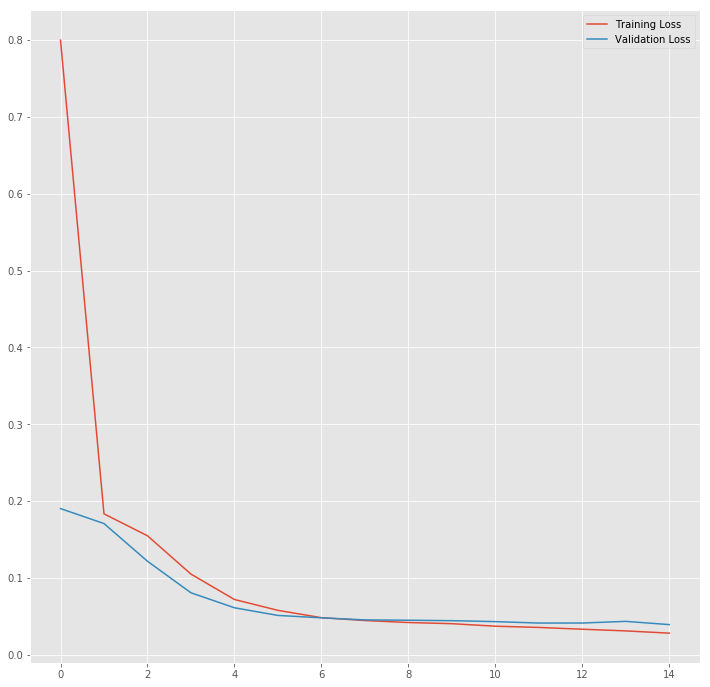

In [23]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["loss"], label='Training Loss')
plt.plot(hist["val_loss"], label='Validation Loss')
plt.legend()
plt.show()

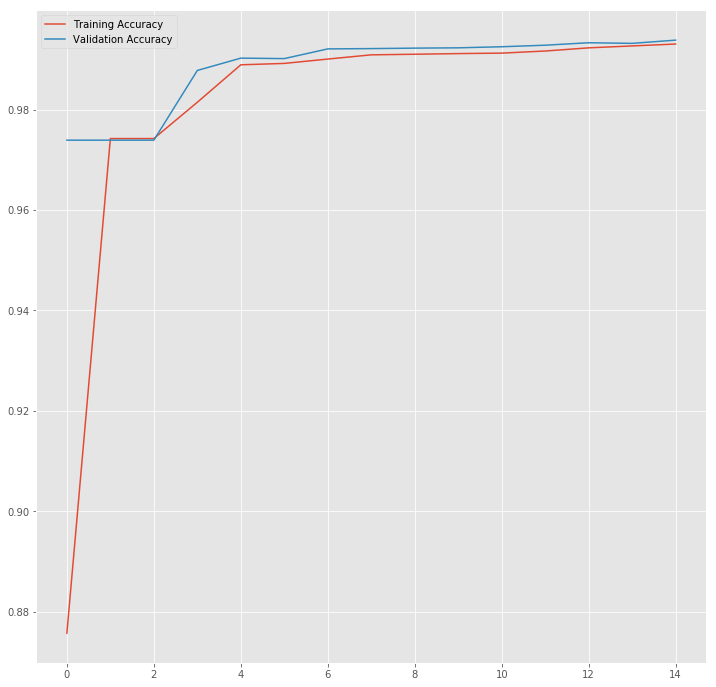

In [24]:
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["viterbi_acc"], label='Training Accuracy')
plt.plot(hist["val_viterbi_acc"], label='Validation Accuracy')
plt.legend()
plt.show()

In [25]:
from sklearn.metrics import classification_report

predicted = model.predict(X_te)

true = []
predicted_val = []
for i in range(len(predicted[:20])):
    p_tmp = np.argmax(predicted[i], axis=-1)
    t_tmp = np.argmax(y_te[i], -1)
    predicted_val.append(p_tmp)
    true.append(t_tmp)

    
p = [list(map(lambda x: idx2tag[x], y)) for y in predicted_val]
t = [list(map(lambda x: idx2tag[x], y)) for y in true]

print predicted_val[2]
print true[2]


print p[2]
print t[2]

report = classification_report(list(itertools.chain.from_iterable(t)), 
                                    list(itertools.chain.from_iterable(p)))
print "\n"
print report

[23 23 23 23 23 23 23 23 67 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23
 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23
 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23
 23 23 23]
[23 23 23 23 23 23 23 23 67 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23
 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23
 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23
 23 23 23]
['NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'CL:0000000', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA']
['NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'CL:0000000', 'NA', 'NA', 'NA', 

/home/sdmohant/.virtualenvs/deeplearn/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sdmohant/.virtualenvs/deeplearn/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [26]:
i = 300
pd = model.predict(np.array([X_te[i]]))
pd = np.argmax(pd, axis=-1)
true = np.argmax(y_te[i], -1)
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")

for w, t1, pred in zip(X_te[i], true, pd[0]):
    if w != 0:
        print("{:15}: {:5} {}".format(words[w-1], tags[t1], tags[pred]))

Word           ||True ||Pred
B              : CL:0000125 CL:0000125
SUMO1          : CL:0000125 CL:0000125
green          : CL:0000125 CL:0000125
and            : CL:0000125 CL:0000125
RBMY           : CL:0000125 CL:0000125
red            : CL:0000125 CL:0000125
immunostaining : CL:0000125 CL:0000125
of             : CL:0000125 CL:0000125
adult          : CL:0000125 CL:0000125
testis         : CL:0000125 CL:0000125
sections       : CL:0000125 CL:0000125
from           : CL:0000125 CL:0000125
wildtype       : CL:0000125 CL:0000125
and            : CL:0000125 CL:0000125
Dmrt7          : CL:0000125 CL:0000125
mutant         : CL:0000125 CL:0000125
Premeiotic     : CL:0000125 CL:0000125
cells          : CL:0000233 CL:0000233
near           : CL:0000125 CL:0000125
the            : CL:0000125 CL:0000125
basal          : CL:0000125 CL:0000125
membrane       : CL:0000125 CL:0000125
express        : CL:0000125 CL:0000125
high           : CL:0000125 CL:0000125
level          : CL:0000125 CL:0000

In [27]:
import pandas as pd

df = pd.DataFrame(
{
    'Predicted' : list(itertools.chain.from_iterable(p)),
    'Ground Truth': list(itertools.chain.from_iterable(t))
}
)


In [28]:
df.to_csv('../data/results/CL_LSTM_Based.tsv', sep='\t')

In [29]:
%run ./accuracy/src/computeSim.py ../data/results/CL_LSTM_Based.tsv ../data/validation_data/CL_AllSubsumers.tsv

Mean semantic similarity:  0.727
